<h2 style="text-align:center">Data Exploration and Data Visualizations</h2>

---

#### 0° - Import Libraries, Datasets and Set Paths

In [262]:
import pandas as pd
import os
import re 
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dateutil import relativedelta
pd.set_option('display.max_columns', None)

In [3]:
pathData = 'data'
pathFigures = 'figures'

In [4]:
# - Legal Categories Data
legalCategoriesPath = os.path.join(pathData, 'categories-juridiques-insee.csv')
legalCategories = pd.read_csv(legalCategoriesPath, low_memory=False, sep=';')

# Legal Form regarding "Auto-Entrepreneur"
lsForm_AutoEntrepreneur = sorted(list(map(lambda num : legalCategories['Code'].iloc[num], filter(lambda num : legalCategories['Libellé'][num]=='Entrepreneur individuel', range(0, len(legalCategories['Libellé']))))))
print(f'List of LEGAL FORM regarding "Auto-Entrepreneur" -> {lsForm_AutoEntrepreneur}')

# Display Sample
legalCategories.sample(2)

List of FORM regarding "Auto-Entrepreneur" -> [1, 10, 1000]


,Code,Libellé
60,63,Société coopérative agricole
260,8290,Autre organisme mutualiste


---
#### 1° - Data Preparation and Computation of General Metrics

In [5]:
def countStateInstitutions(data_SI):
    data_SI = data_SI.merge(data_SI.groupby('siren')['siren'].count().reset_index(name='NUM_INSTITUTIONS'), on='siren')
    data_SI_Count = data_SI.groupby(['siren', 'etatAdministratifEtablissement'])['etatAdministratifEtablissement'].count().reset_index(name='count')
    data_SI = data_SI.merge(data_SI_Count[data_SI_Count['etatAdministratifEtablissement']=='A'][['siren', 'count']].rename(columns={'count':'NUM_INSTITUTIONS_ACTIVE'}), on='siren', how='outer')
    data_SI = data_SI.merge(data_SI_Count[data_SI_Count['etatAdministratifEtablissement']=='F'][['siren', 'count']].rename(columns={'count':'NUM_INSTITUTIONS_CLOSE'}), on='siren', how='outer')
    return data_SI[data_SI['etablissementSiege']==True]

In [6]:
def existingDays(rowInf):
    try:
        if rowInf['etatAdministratifUniteLegale'] == 'C':
            return (datetime.datetime.strptime(rowInf['dateDebut'], '%Y-%m-%d') - datetime.datetime.strptime(rowInf['dateCreationUniteLegale'], '%Y-%m-%d')).days
        return (datetime.datetime.today() - datetime.datetime.strptime(rowInf['dateCreationUniteLegale'], '%Y-%m-%d')).days
    except:
        return None

In [7]:
def mapCreateDate(dateCreation, lsYears = [1], lsAssociatedLabels = ['Less than a Year', 'More than a Year']):
    if not isinstance(dateCreation, str):
        return 'No Information'
    dateCreation = datetime.datetime.strptime(dateCreation, '%Y-%m-%d')
    for idc, yearVal in enumerate(lsYears):
        if datetime.datetime.now() - relativedelta.relativedelta(years=yearVal) < dateCreation:
            return lsAssociatedLabels[idc]
    return lsAssociatedLabels[-1]

In [8]:
# Read StockUniteLegale Files
path_SE = os.path.join(pathData, 'StockEtablissement', 'SECTION')
path_SUL = os.path.join(pathData, 'StockUniteLegale', 'SECTION')

lsFiles_SE, lsFiles_SUL = os.listdir(path_SE), os.listdir(path_SUL)
db_SE_SUL = pd.DataFrame()  # Database about the STOCK UNITE LEGALE and regarding their EXISTING TIME

# Loop through each Files (Section)
for fileSE, file_SUL in zip(lsFiles_SE, lsFiles_SUL):
    curSection = re.compile("SECTION_(.*)$").search(file_SUL).group(1)[0]
    print(f'Current Section -> "{curSection}"')
    df_SE = pd.read_csv(filepath_or_buffer = os.path.join(path_SE, fileSE), index_col = 0, low_memory = False)
    df_SE = countStateInstitutions(df_SE)
    
    df_SUL = pd.read_csv(filepath_or_buffer = os.path.join(path_SUL, file_SUL), index_col = 0, low_memory = False)
    df_SUL = df_SUL.dropna(subset='dateCreationUniteLegale')
    df_SUL['SECTION'] = curSection
    df_SUL['DAYS_SCREATION'] = df_SUL.apply(lambda row : existingDays(row), axis=1)
    df_SUL['CreatedSince'] = df_SUL['dateCreationUniteLegale'].apply(lambda dcreation : (datetime.datetime.today() - datetime.datetime.strptime(dcreation, '%Y-%m-%d')).days/365.25)
    
    lsYears, lsAssLabels = [3, 5, 10, 20], ['Less than 3 Years', 'Between 3 and 5 Years', 'Between 5 and 10 Years', 'Between 10 and 20 Years', 'More than 20 Years']
    df_SUL['CREATION_LABELS'] = df_SUL['dateCreationUniteLegale'].apply(lambda dcreation: mapCreateDate(dcreation, lsYears, lsAssLabels))

    

    db_SE_SUL = pd.concat([db_SE_SUL, df_SUL.merge(df_SE, on='siren')])

Current Section -> "A"
Current Section -> "B"
Current Section -> "C"
Current Section -> "D"
Current Section -> "E"
Current Section -> "F"
Current Section -> "G"
Current Section -> "H"
Current Section -> "I"
Current Section -> "J"
Current Section -> "K"
Current Section -> "L"
Current Section -> "M"
Current Section -> "N"
Current Section -> "O"
Current Section -> "P"
Current Section -> "Q"
Current Section -> "R"
Current Section -> "S"
Current Section -> "T"
Current Section -> "U"


In [9]:
keepColumns = ['SECTION', 'siren', 'nic', 'siret', 'dateCreationUniteLegale', 'sexeUniteLegale', 'dateDebut_x', 'etatAdministratifUniteLegale',
               'categorieJuridiqueUniteLegale', 'activitePrincipaleUniteLegale', 'nomenclatureActivitePrincipaleUniteLegale',
               'nicSiegeUniteLegale', 'caractereEmployeurUniteLegale', 'codePostalEtablissement', 'libelleCommuneEtablissement', 
               'codeCommuneEtablissement', 'etatAdministratifEtablissement', 'NUM_INSTITUTIONS', 'NUM_INSTITUTIONS_ACTIVE', 'NUM_INSTITUTIONS_CLOSE', 'DAYS_SCREATION', 'CreatedSince', 'CREATION_LABELS']
db_comp_SE_SUL = db_SE_SUL[keepColumns]

renameColumns = {'dateDebut_x': 'dateDebut'}
db_comp_SE_SUL = db_comp_SE_SUL.rename(columns=renameColumns)

In [10]:
db_SE_SUL.to_csv(os.path.join(pathData, 'StockEtablissement-StockUniteLegale-FULL.csv'))
db_comp_SE_SUL.to_csv(os.path.join(pathData, 'StockEtablissement-StockUniteLegale-LIGHT.csv'))

---
#### 2° - Institution Creation 

In [12]:
db_comp_SE_SUL.sample(3)

,SECTION,siren,nic,siret,dateCreationUniteLegale,sexeUniteLegale,dateDebut,etatAdministratifUniteLegale,categorieJuridiqueUniteLegale,activitePrincipaleUniteLegale,nomenclatureActivitePrincipaleUniteLegale,nicSiegeUniteLegale,caractereEmployeurUniteLegale,codePostalEtablissement,libelleCommuneEtablissement,codeCommuneEtablissement,etatAdministratifEtablissement,NUM_INSTITUTIONS,NUM_INSTITUTIONS_ACTIVE,NUM_INSTITUTIONS_CLOSE,DAYS_SCREATION,CreatedSince,CREATION_LABELS
941213,F,793845082,23,79384508200023,2013-07-01,M,2020-10-08,A,1000.0,43.34Z,NAFRev2,23,N,73000.0,CHAMBERY,73065,A,2,1.0,1.0,3523.0,9.645448,Between 5 and 10 Years
482222,R,789655404,34,78965540400034,2000-09-13,NaN,2017-07-16,A,9220.0,93.12Z,NAFRev2,34,O,97424.0,SAINT-LEU,97413,A,3,1.0,2.0,8197.0,22.442163,More than 20 Years
161717,F,382450310,26,38245031000026,1991-04-26,M,2021-07-01,A,1000.0,43.21A,NAFRev2,26,N,97160.0,LE MOULE,97117,A,1,1.0,NaN,11625.0,31.827515,More than 20 Years


##### -> Distribution VS Section & Administrative State

In [13]:
db_DSAS = db_comp_SE_SUL.copy()
db_DSAS['SECTION'] = db_DSAS.SECTION.apply(lambda section_ : f'SECTION {section_}')
db_DSAS['etatAdministratifUniteLegale'] = np.where(db_DSAS['etatAdministratifUniteLegale']=='A', 'Active', 'Closed')
db_DSAS = db_DSAS.groupby(['SECTION', 'etatAdministratifUniteLegale'])['SECTION'].count().reset_index(name='NUM_OBSERVATIONS')
db_DSAS['PERCENTAGE_OBSERVATIONS'] = (db_DSAS.NUM_OBSERVATIONS / np.nansum(db_DSAS.NUM_OBSERVATIONS) * 100)
db_DSAS.sample(3)

,SECTION,etatAdministratifUniteLegale,NUM_OBSERVATIONS,PERCENTAGE_OBSERVATIONS
5,SECTION C,Closed,176551,1.003650
3,SECTION B,Closed,922,0.005241
23,SECTION L,Closed,444277,2.525608


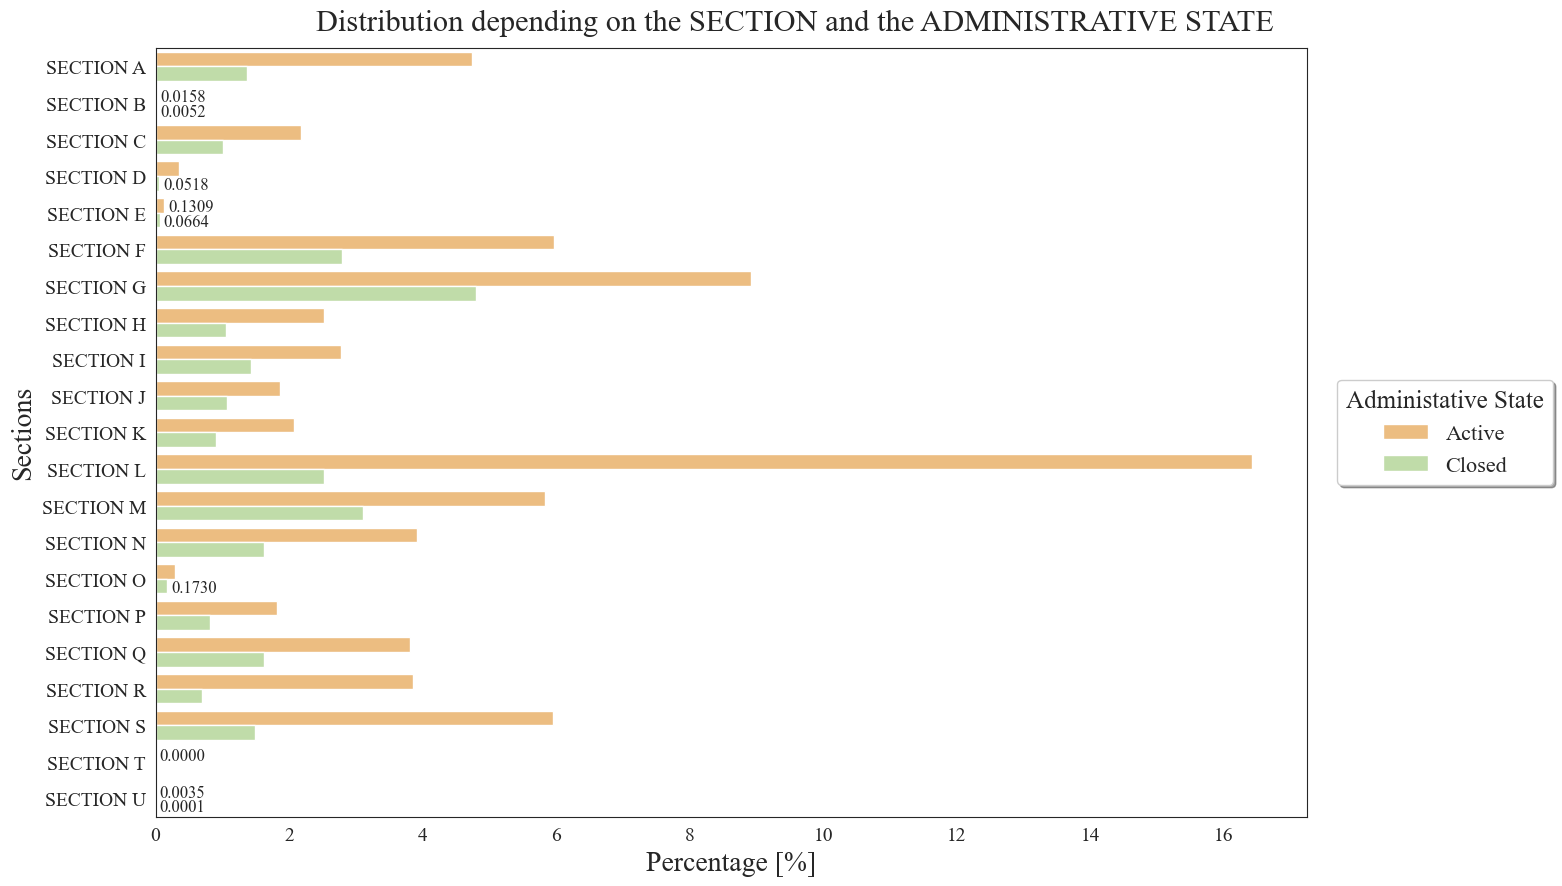

In [14]:
# Build the Figure
sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(16, 9), sharey=True)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rc('font',family='Times New Roman')

# Axis
order_axis = db_DSAS.SECTION.sort_values(ascending=True).unique().tolist()
order_hue = db_DSAS.etatAdministratifUniteLegale.sort_values(ascending=True).unique().tolist()
ax = sns.barplot(x = "PERCENTAGE_OBSERVATIONS", y = "SECTION", data = db_DSAS, hue = "etatAdministratifUniteLegale", hue_order=order_hue, palette = "Spectral", errorbar=('ci', 68), capsize= 0.05)
ax.set_xlabel("Percentage [%]", size=20)
ax.set_ylabel("Sections", size=20)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
leg = ax.legend(loc='center', bbox_to_anchor=(1.12, 0.5), shadow=True, prop={'size':16, 'family': 'Times New Roman' }, labelspacing=0.5)
leg.set_title('Administative State', prop = {'size': 18, 'family':'Times New Roman'})

# Annotation
for p in ax.patches:
    if p.get_width() < 0.2: 
        _x = p.get_x() + p.get_width() + 0.40
        _y = p.get_y() + p.get_height() - 0.05
        value = '{:.4f}'.format(p.get_width())
        ax.text(_x, _y, value, ha="center", fontsize = 12, fontname = "Times New Roman") 


#Figure
fig.suptitle("Distribution depending on the SECTION and the ADMINISTRATIVE STATE", ha = 'center', size=22)
fig.tight_layout()
fig.subplots_adjust(right=0.82)

#Save Figure
pathFile = os.path.join(pathFigures, 'Création & Cessation - Unité Légale', "Barplots - Distribution on SECTION & ADMINISTRATIVE STATE")
os.makedirs(os.path.dirname(pathFile), exist_ok=True)
fig.savefig(pathFile)

##### -> Average Days/Months/Years since Creation VS Section & Administrative State

In [15]:
db_DsC = db_comp_SE_SUL.copy()
db_DsC['SECTION'] = db_DsC.SECTION.apply(lambda section_ : f'SECTION {section_}')
db_DsC['etatAdministratifUniteLegale'] = np.where(db_DsC['etatAdministratifUniteLegale']=='A', 'Active', 'Closed')
db_DsC['YEARS_SCREATION'] = db_DsC['DAYS_SCREATION']/(365.25)
db_DsC['MONTHS_SCREATION'] = db_DsC['YEARS_SCREATION']*12
db_DsC = db_DsC.groupby(['SECTION', 'etatAdministratifUniteLegale']).agg({'DAYS_SCREATION': ['mean'], 'MONTHS_SCREATION': ['mean'], 'YEARS_SCREATION':['mean']})
db_DsC.columns = ['MEAN_DAYS_SCREATION', 'MEAN_MONTHS_SCREATION', 'MEAN_YEARS_SCREATION']
db_DsC = db_DsC.reset_index()
db_DsC.sample(3)

,SECTION,etatAdministratifUniteLegale,MEAN_DAYS_SCREATION,MEAN_MONTHS_SCREATION,MEAN_YEARS_SCREATION
37,SECTION S,Closed,3404.910982,111.865659,9.322138
30,SECTION P,Active,5549.242076,182.315961,15.192997
7,SECTION D,Closed,2693.366707,88.488434,7.374036


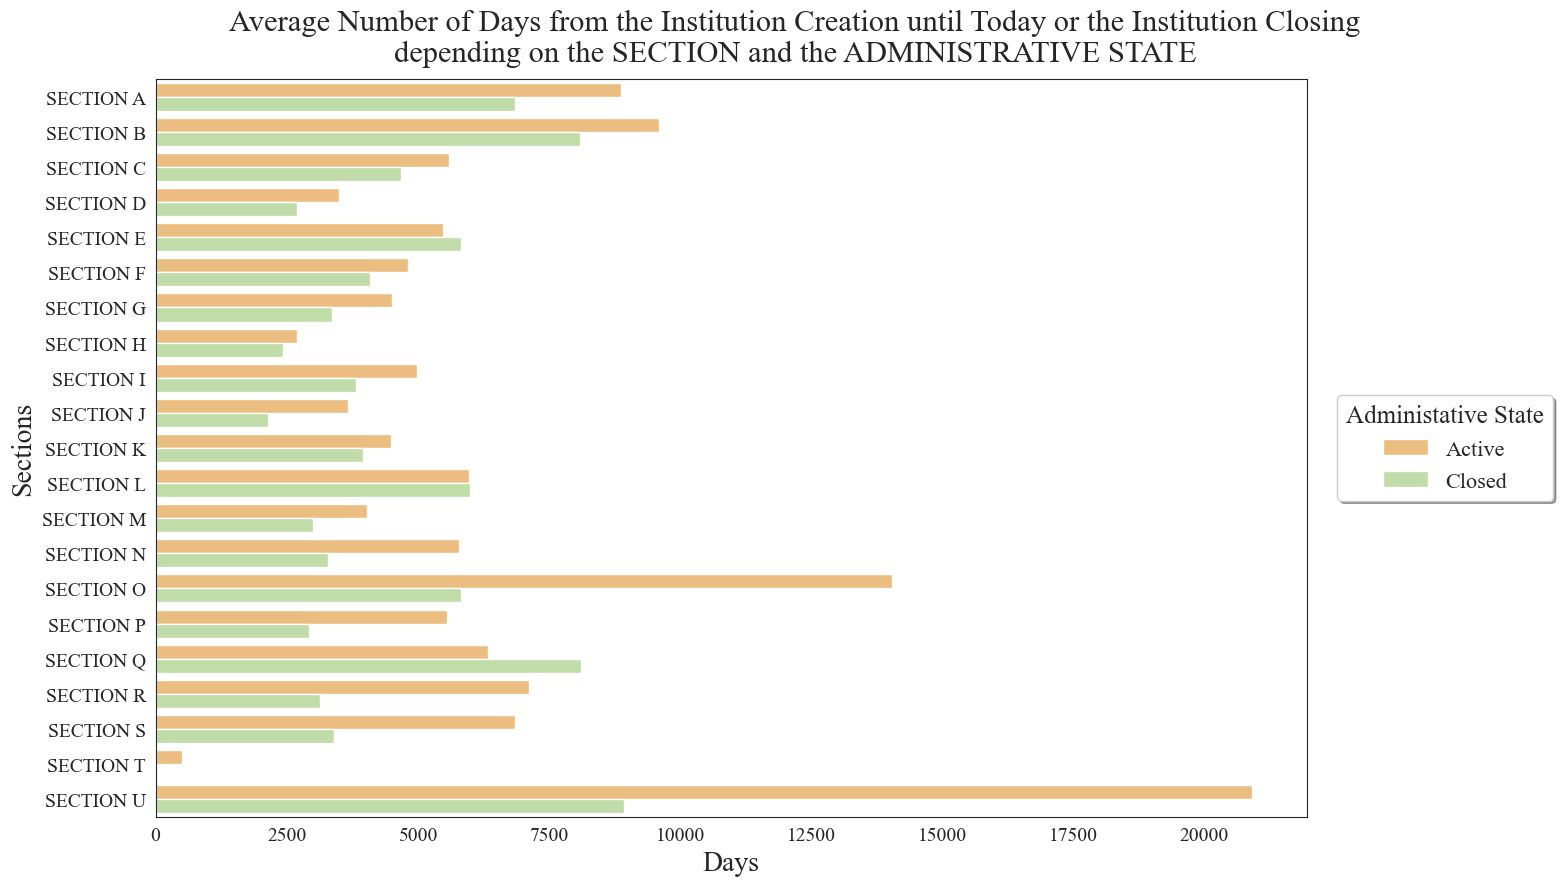

In [16]:
# Build the Figure
sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(16, 9), sharey=True)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rc('font',family='Times New Roman')

# Axis
order_axis = db_DsC.SECTION.sort_values(ascending=True).unique().tolist()
order_hue = db_DsC.etatAdministratifUniteLegale.sort_values(ascending=True).unique().tolist()
ax = sns.barplot(x = "MEAN_DAYS_SCREATION", y = "SECTION", data = db_DsC, hue = "etatAdministratifUniteLegale", hue_order=order_hue, palette = "Spectral", errorbar=('ci', 68), capsize= 0.05)
ax.set_xlabel("Days", size=20)
ax.set_ylabel("Sections", size=20)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
leg = ax.legend(loc='center', bbox_to_anchor=(1.12, 0.5), shadow=True, prop={'size':16, 'family': 'Times New Roman' }, labelspacing=0.5)
leg.set_title('Administative State', prop = {'size': 18, 'family':'Times New Roman'})

# Annotation
for p in ax.patches:
    if p.get_width() < 0.2: 
        _x = p.get_x() + p.get_width() + 0.40
        _y = p.get_y() + p.get_height() - 0.05
        value = '{:.4f}'.format(p.get_width())
        ax.text(_x, _y, value, ha="center", fontsize = 12, fontname = "Times New Roman") 


#Figure
fig.suptitle("Average Number of Days from the Institution Creation until Today or the Institution Closing\ndepending on the SECTION and the ADMINISTRATIVE STATE", ha = 'center', size=22)
fig.tight_layout()
fig.subplots_adjust(right=0.82)

#Save Figure
pathFile = os.path.join(pathFigures, 'Création & Cessation - Unité Légale', "Barplots - Average Number of Days on SECTION & ADMINISTRATIVE STATE")
os.makedirs(os.path.dirname(pathFile), exist_ok=True)
fig.savefig(pathFile)

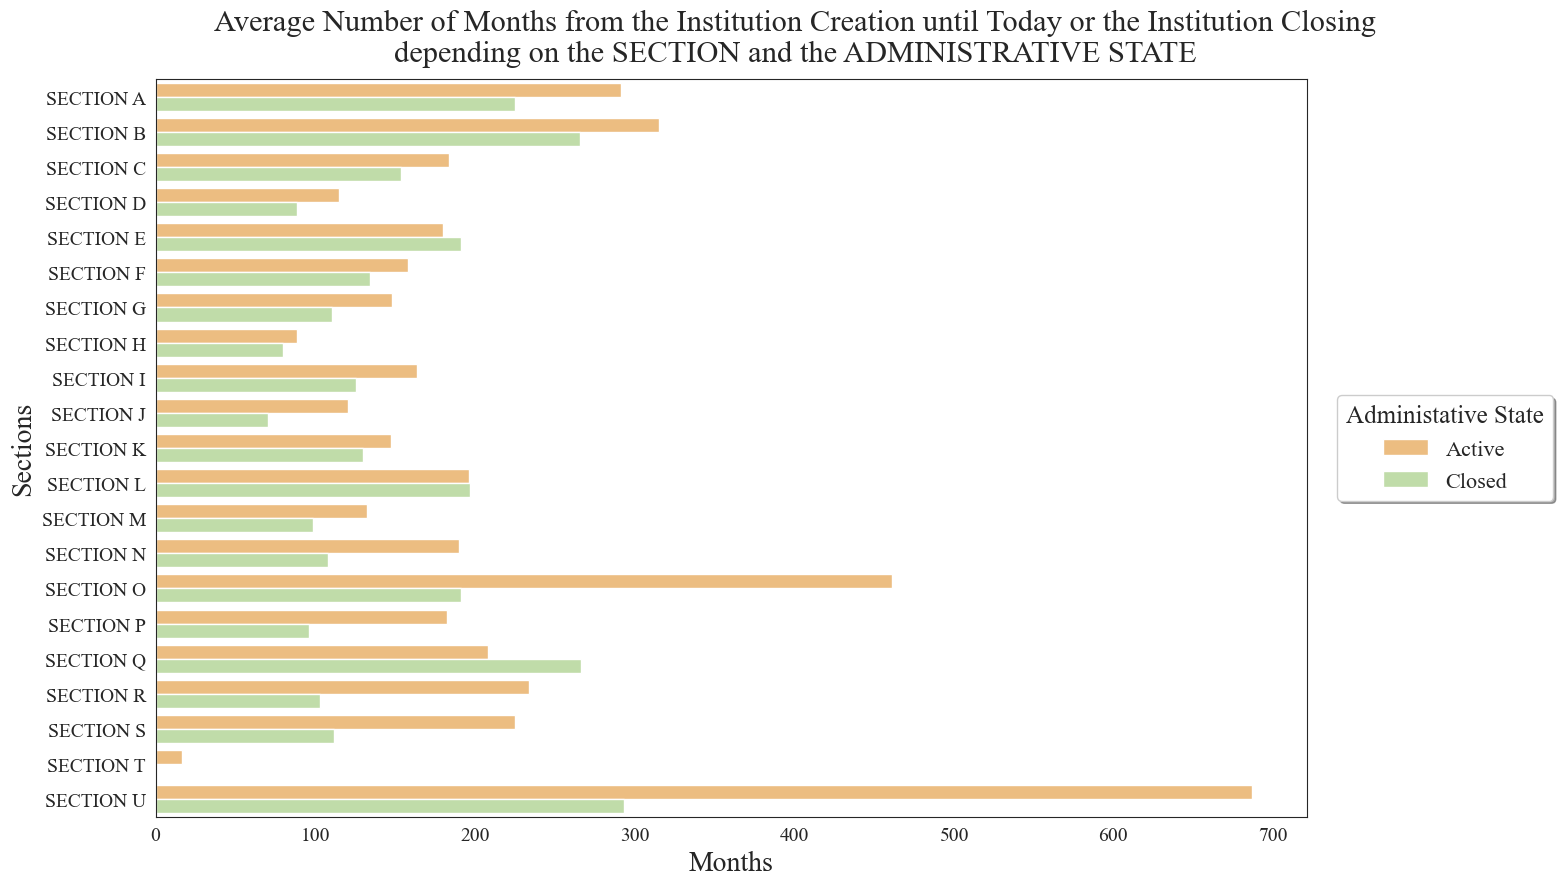

In [17]:
# Build the Figure
sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(16, 9), sharey=True)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rc('font',family='Times New Roman')

# Axis
order_axis = db_DsC.SECTION.sort_values(ascending=True).unique().tolist()
order_hue = db_DsC.etatAdministratifUniteLegale.sort_values(ascending=True).unique().tolist()
ax = sns.barplot(x = "MEAN_MONTHS_SCREATION", y = "SECTION", data = db_DsC, hue = "etatAdministratifUniteLegale", hue_order=order_hue, palette = "Spectral", errorbar=('ci', 68), capsize= 0.05)
ax.set_xlabel("Months", size=20)
ax.set_ylabel("Sections", size=20)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
leg = ax.legend(loc='center', bbox_to_anchor=(1.12, 0.5), shadow=True, prop={'size':16, 'family': 'Times New Roman' }, labelspacing=0.5)
leg.set_title('Administative State', prop = {'size': 18, 'family':'Times New Roman'})

# Annotation
for p in ax.patches:
    if p.get_width() < 0.2: 
        _x = p.get_x() + p.get_width() + 0.40
        _y = p.get_y() + p.get_height() - 0.05
        value = '{:.4f}'.format(p.get_width())
        ax.text(_x, _y, value, ha="center", fontsize = 12, fontname = "Times New Roman") 


#Figure
fig.suptitle("Average Number of Months from the Institution Creation until Today or the Institution Closing\ndepending on the SECTION and the ADMINISTRATIVE STATE", ha = 'center', size=22)
fig.tight_layout()
fig.subplots_adjust(right=0.82)

#Save Figure
pathFile = os.path.join(pathFigures, 'Création & Cessation - Unité Légale', "Barplots - Average Number of Months on SECTION & ADMINISTRATIVE STATE")
os.makedirs(os.path.dirname(pathFile), exist_ok=True)
fig.savefig(pathFile)

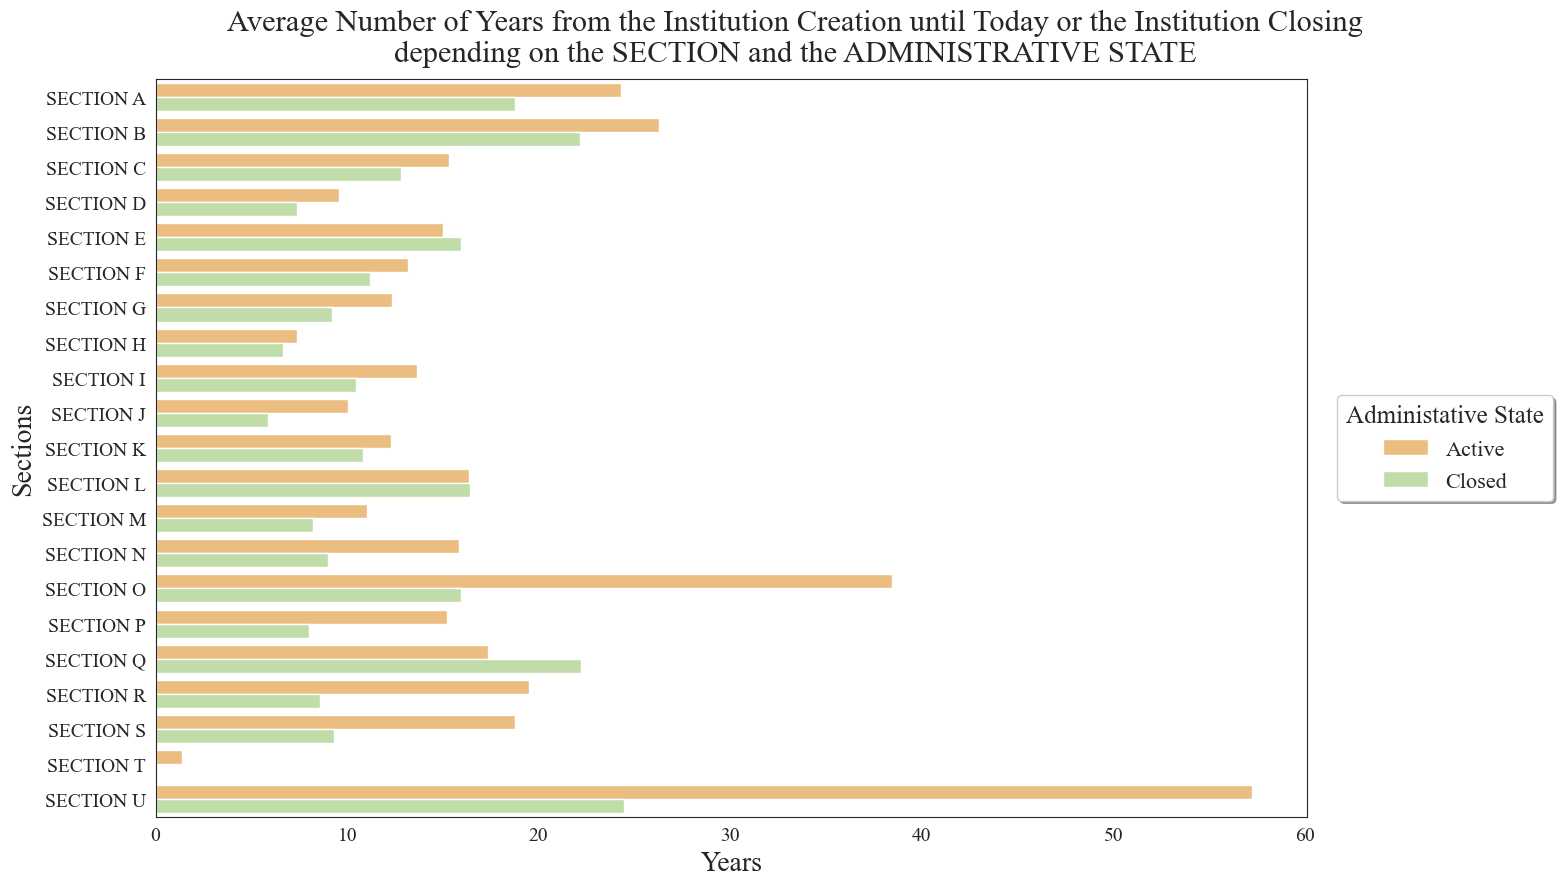

In [18]:
# Build the Figure
sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(16, 9), sharey=True)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rc('font',family='Times New Roman')

# Axis
order_axis = db_DsC.SECTION.sort_values(ascending=True).unique().tolist()
order_hue = db_DsC.etatAdministratifUniteLegale.sort_values(ascending=True).unique().tolist()
ax = sns.barplot(x = "MEAN_YEARS_SCREATION", y = "SECTION", data = db_DsC, hue = "etatAdministratifUniteLegale", hue_order=order_hue, palette = "Spectral", errorbar=('ci', 68), capsize= 0.05)
ax.set_xlabel("Years", size=20)
ax.set_ylabel("Sections", size=20)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
leg = ax.legend(loc='center', bbox_to_anchor=(1.12, 0.5), shadow=True, prop={'size':16, 'family': 'Times New Roman' }, labelspacing=0.5)
leg.set_title('Administative State', prop = {'size': 18, 'family':'Times New Roman'})

# Annotation
for p in ax.patches:
    if p.get_width() < 0.2: 
        _x = p.get_x() + p.get_width() + 0.40
        _y = p.get_y() + p.get_height() - 0.05
        value = '{:.4f}'.format(p.get_width())
        ax.text(_x, _y, value, ha="center", fontsize = 12, fontname = "Times New Roman") 


#Figure
fig.suptitle("Average Number of Years from the Institution Creation until Today or the Institution Closing\ndepending on the SECTION and the ADMINISTRATIVE STATE", ha = 'center', size=22)
fig.tight_layout()
fig.subplots_adjust(right=0.82)

#Save Figure
pathFile = os.path.join(pathFigures, 'Création & Cessation - Unité Légale', "Barplots - Average Number of Years on SECTION & ADMINISTRATIVE STATE")
os.makedirs(os.path.dirname(pathFile), exist_ok=True)
fig.savefig(pathFile)

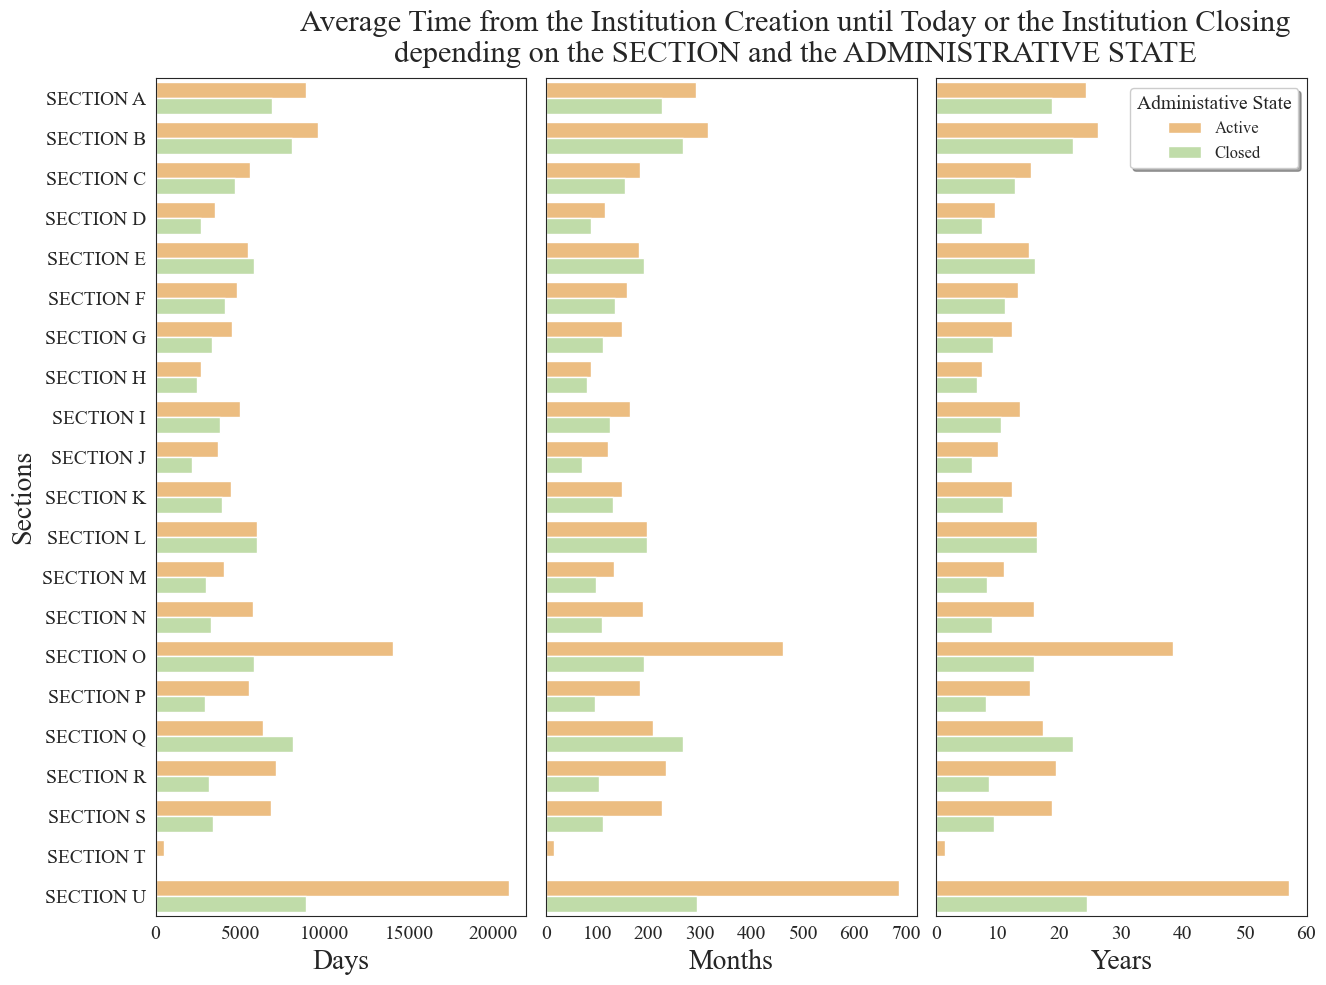

In [19]:
# Build the Figure
sns.set_style("white")
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(16, 10), sharey=True)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rc('font',family='Times New Roman')

# Axis
order_axis = db_DsC.SECTION.sort_values(ascending=True).unique().tolist()
order_hue = db_DsC.etatAdministratifUniteLegale.sort_values(ascending=True).unique().tolist()
sns.barplot(x = "MEAN_DAYS_SCREATION", y = "SECTION", data = db_DsC, hue = "etatAdministratifUniteLegale", hue_order=order_hue, palette = "Spectral", errorbar=('ci', 68), capsize= 0.05, ax=ax1)
ax1.set_xlabel("Days", size=20)
ax1.set_ylabel("Sections", size=20)
plt.setp(ax1.get_xticklabels(), fontsize=14)
plt.setp(ax1.get_yticklabels(), fontsize=14)
ax1.legend([], [], frameon=False)

sns.barplot(x = "MEAN_MONTHS_SCREATION", y = "SECTION", data = db_DsC, hue = "etatAdministratifUniteLegale", hue_order=order_hue, palette = "Spectral", errorbar=('ci', 68), capsize= 0.05, ax=ax2)
ax2.set_xlabel("Months", size=20)
ax2.set_ylabel('')
plt.setp(ax2.get_xticklabels(), fontsize=14)
ax2.legend([], [], frameon=False)

sns.barplot(x = "MEAN_YEARS_SCREATION", y = "SECTION", data = db_DsC, hue = "etatAdministratifUniteLegale", hue_order=order_hue, palette = "Spectral", errorbar=('ci', 68), capsize= 0.05, ax=ax3)
ax3.set_xlabel("Years", size=20)
ax3.set_ylabel('')
plt.setp(ax3.get_xticklabels(), fontsize=14)
leg = ax3.legend(loc='center', bbox_to_anchor=(0.75, 0.94), shadow=True, prop={'size':12, 'family': 'Times New Roman' }, labelspacing=0.5)
leg.set_title('Administative State', prop = {'size': 14, 'family':'Times New Roman'})


#Figure
fig.suptitle("Average Time from the Institution Creation until Today or the Institution Closing\ndepending on the SECTION and the ADMINISTRATIVE STATE", ha = 'center', size=22)
fig.tight_layout()
fig.subplots_adjust(right=0.82)

#Save Figure
pathFile = os.path.join(pathFigures, 'Création & Cessation - Unité Légale', "Barplots - Average Time on SECTION & ADMINISTRATIVE STATE")
os.makedirs(os.path.dirname(pathFile), exist_ok=True)
fig.savefig(pathFile)

In [36]:
db_DsC_s2010 = db_comp_SE_SUL.copy()
db_DsC_s2010['SECTION'] = db_DsC_s2010.SECTION.apply(lambda section_ : f'SECTION {section_}')
db_DsC_s2010['etatAdministratifUniteLegale'] = np.where(db_DsC_s2010['etatAdministratifUniteLegale']=='A', 'Active', 'Closed')
db_DsC_s2010['YEAR_CREATION'] = db_DsC_s2010['dateCreationUniteLegale'].apply(lambda dtcrea : int(dtcrea.split('-')[0]))
db_DsC_s2010 = db_DsC_s2010[db_DsC_s2010.YEAR_CREATION >= 2010]
db_DsC_s2010['YEARS_SCREATION'] = db_DsC_s2010['DAYS_SCREATION']/(365.25)
db_DsC_s2010['MONTHS_SCREATION'] = db_DsC_s2010['YEARS_SCREATION']*12
db_DsC_s2010 = db_DsC_s2010.groupby(['SECTION', 'etatAdministratifUniteLegale']).agg({'DAYS_SCREATION': ['mean'], 'MONTHS_SCREATION': ['mean'], 'YEARS_SCREATION':['mean']})
db_DsC_s2010.columns = ['MEAN_DAYS_SCREATION', 'MEAN_MONTHS_SCREATION', 'MEAN_YEARS_SCREATION']
db_DsC_s2010 = db_DsC_s2010.reset_index()
db_DsC_s2010.sample(3)


,SECTION,etatAdministratifUniteLegale,MEAN_DAYS_SCREATION,MEAN_MONTHS_SCREATION,MEAN_YEARS_SCREATION
26,SECTION N,Active,1876.314186,61.644819,5.137068
4,SECTION C,Active,2018.704108,66.322928,5.526911
12,SECTION G,Active,1965.749642,64.583150,5.381929


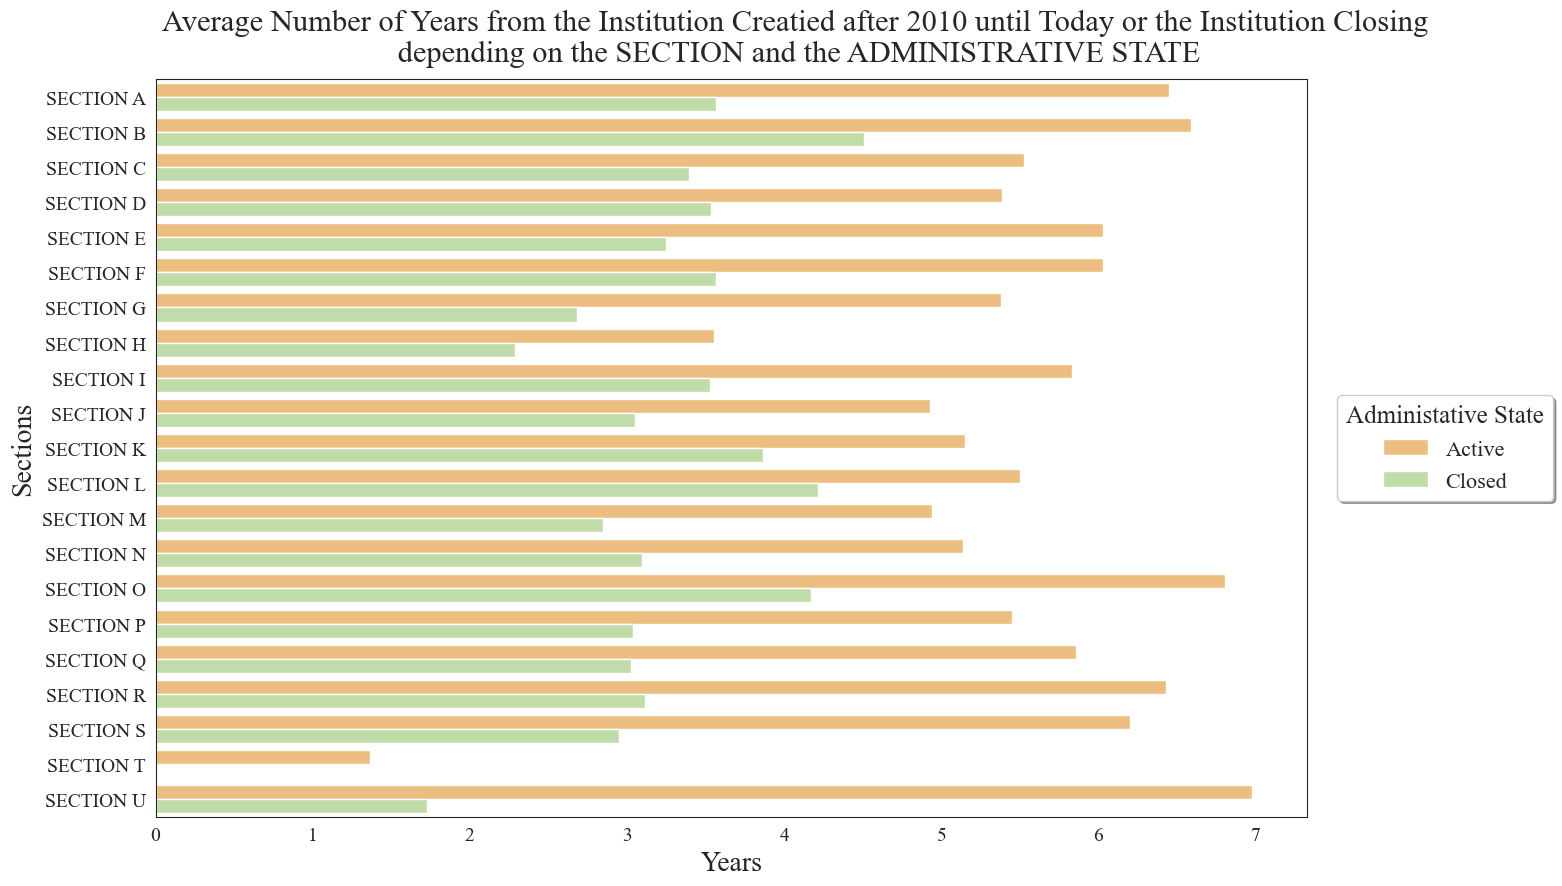

In [39]:
# Build the Figure
sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(16, 9), sharey=True)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rc('font',family='Times New Roman')

# Axis
order_axis = db_DsC_s2010.SECTION.sort_values(ascending=True).unique().tolist()
order_hue = db_DsC_s2010.etatAdministratifUniteLegale.sort_values(ascending=True).unique().tolist()
ax = sns.barplot(x = "MEAN_YEARS_SCREATION", y = "SECTION", data = db_DsC_s2010, hue = "etatAdministratifUniteLegale", hue_order=order_hue, palette = "Spectral", errorbar=('ci', 68), capsize= 0.05)
ax.set_xlabel("Years", size=20)
ax.set_ylabel("Sections", size=20)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
leg = ax.legend(loc='center', bbox_to_anchor=(1.12, 0.5), shadow=True, prop={'size':16, 'family': 'Times New Roman' }, labelspacing=0.5)
leg.set_title('Administative State', prop = {'size': 18, 'family':'Times New Roman'})

# Annotation
for p in ax.patches:
    if p.get_width() < 0.2: 
        _x = p.get_x() + p.get_width() + 0.40
        _y = p.get_y() + p.get_height() - 0.05
        value = '{:.4f}'.format(p.get_width())
        ax.text(_x, _y, value, ha="center", fontsize = 12, fontname = "Times New Roman") 


#Figure
fig.suptitle("Average Number of Years from the Institution Creatied after 2010 until Today or the Institution Closing\n depending on the SECTION and the ADMINISTRATIVE STATE", ha = 'center', size=22)
fig.tight_layout()
fig.subplots_adjust(right=0.82)

#Save Figure
pathFile = os.path.join(pathFigures, 'Création & Cessation - Unité Légale', "Barplots - Average Number of Years on SECTION & ADMINISTRATIVE STATE Since 2010")
os.makedirs(os.path.dirname(pathFile), exist_ok=True)
fig.savefig(pathFile)

##### -> Institution Creation depending on the Years & Section

In [21]:
db_YsC = db_comp_SE_SUL.copy()
db_YsC['SECTION'] = db_YsC.SECTION.apply(lambda section_ : f'SECTION {section_}')
db_YsC['etatAdministratifUniteLegale'] = np.where(db_YsC['etatAdministratifUniteLegale']=='A', 'Active', 'Closed')
db_YsC.sample(3)

,SECTION,siren,nic,siret,dateCreationUniteLegale,sexeUniteLegale,dateDebut,etatAdministratifUniteLegale,categorieJuridiqueUniteLegale,activitePrincipaleUniteLegale,nomenclatureActivitePrincipaleUniteLegale,nicSiegeUniteLegale,caractereEmployeurUniteLegale,codePostalEtablissement,libelleCommuneEtablissement,codeCommuneEtablissement,etatAdministratifEtablissement,NUM_INSTITUTIONS,NUM_INSTITUTIONS_ACTIVE,NUM_INSTITUTIONS_CLOSE,DAYS_SCREATION,CreatedSince,CREATION_LABELS
647841,SECTION A,481707818,11,48170781800011,2001-02-27,M,2008-01-01,Active,1000.0,02.10Z,NAFRev2,11,N,69790.0,SAINT-IGNY-DE-VERS,69209,A,1,1.0,NaN,8030.0,21.984942,More than 20 Years
408535,SECTION M,503301517,28,50330151700028,2008-03-20,M,2013-04-24,Closed,1000.0,73.12Z,NAFRev2,28,N,40230.0,BENESSE-MAREMNE,40036,F,1,NaN,1.0,1861.0,14.926762,Between 10 and 20 Years
302608,SECTION G,408022986,33,40802298600033,1996-07-02,F,2009-09-25,Closed,1000.0,47.79Z,NAFRev2,33,N,31800.0,SAINT-GAUDENS,31483,F,1,NaN,1.0,4833.0,26.642026,More than 20 Years


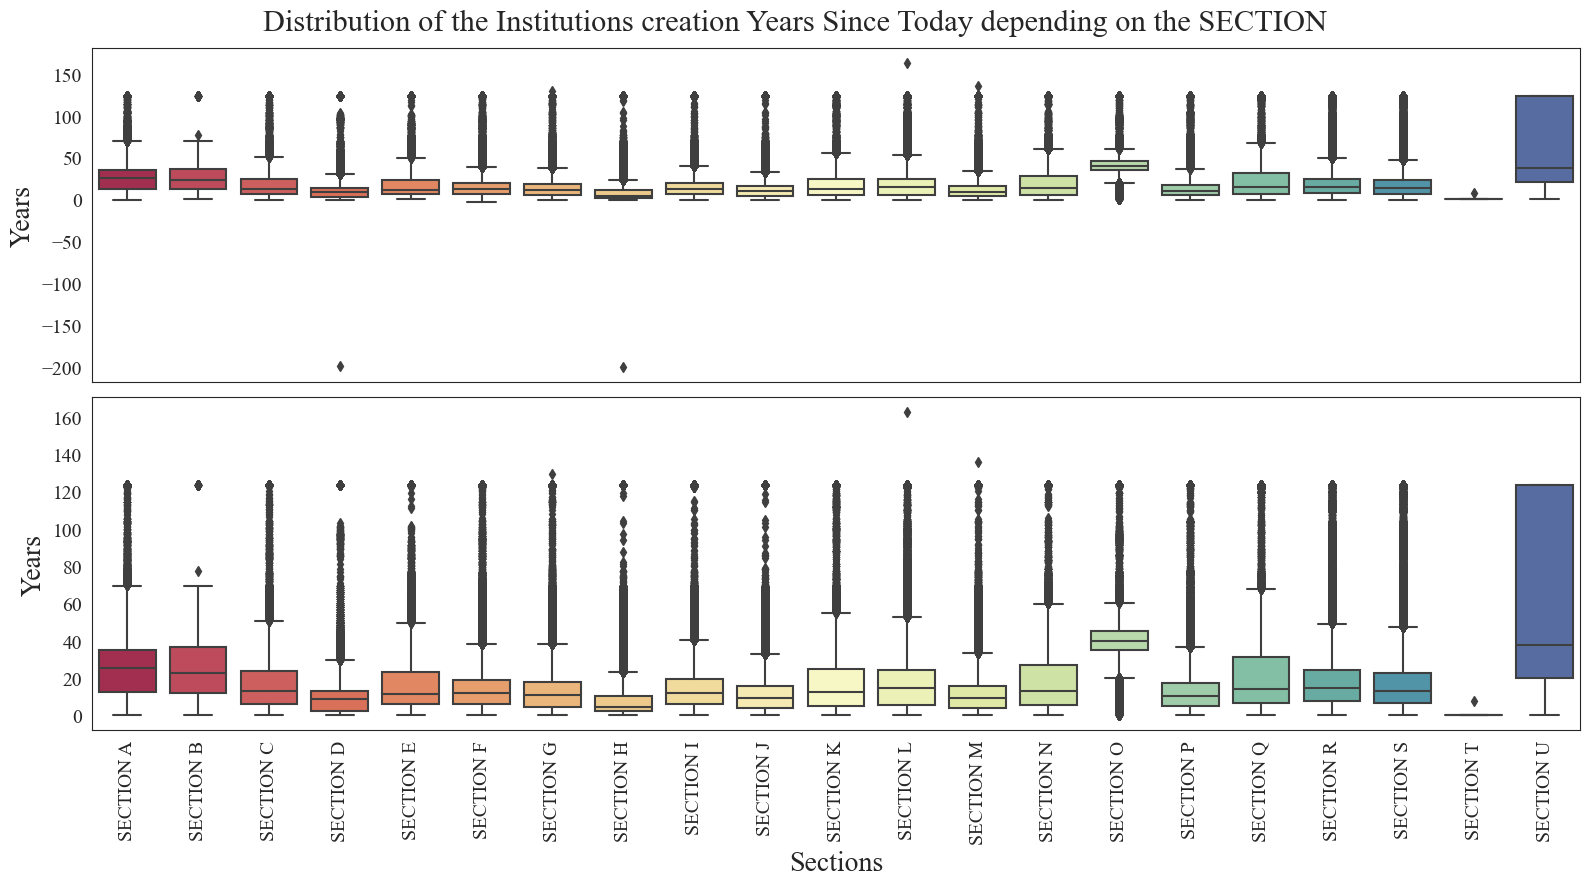

In [30]:
# Build the Figure
sns.set_style("white")
fig, [ax1,ax2] = plt.subplots(2, 1, figsize=(16, 9), sharey=False)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rc('font', family='Times New Roman')

# Axis
sns.boxplot(x = "SECTION", y = "CreatedSince", data = db_YsC, palette = "Spectral", ax=ax1)
ax1.set_ylabel("Years", size=20)
plt.setp(ax1.get_yticklabels(), fontsize=14)
ax1.set(xticklabels=[])
ax1.set(xlabel=None)

sns.boxplot(x = "SECTION", y = "CreatedSince", data = db_YsC[db_YsC.CreatedSince > 0], palette = "Spectral", ax=ax2)
ax2.set_xlabel("Sections", size=20)
ax2.set_ylabel("Years", size=20)
plt.setp(ax2.get_xticklabels(), fontsize=14, rotation=90)
plt.setp(ax2.get_yticklabels(), fontsize=14)


#Figure
fig.suptitle("Distribution of the Institutions creation Years Since Today depending on the SECTION", ha = 'center', size=22)
fig.tight_layout()

#Save Figure
pathFile = os.path.join(pathFigures, 'Création & Cessation - Unité Légale', "Boxplots - Distribution of the Years since the Creation of the Institution on SECTION")
os.makedirs(os.path.dirname(pathFile), exist_ok=True)
fig.savefig(pathFile)

In [41]:
db_YsC.sort_values(by='dateCreationUniteLegale')

,SECTION,siren,nic,siret,dateCreationUniteLegale,sexeUniteLegale,dateDebut,etatAdministratifUniteLegale,categorieJuridiqueUniteLegale,activitePrincipaleUniteLegale,nomenclatureActivitePrincipaleUniteLegale,nicSiegeUniteLegale,caractereEmployeurUniteLegale,codePostalEtablissement,libelleCommuneEtablissement,codeCommuneEtablissement,etatAdministratifEtablissement,NUM_INSTITUTIONS,NUM_INSTITUTIONS_ACTIVE,NUM_INSTITUTIONS_CLOSE,DAYS_SCREATION,CreatedSince,CREATION_LABELS
1067276,SECTION L,444263164,14,44426316400014,1860-07-22,NaN,2020-01-24,Active,6540.0,68.20A,NAFRev2,14,N,78113.0,CONDE-SUR-VESGRE,78171,A,1,1.0,NaN,59384.0,162.584531,More than 20 Years
694890,SECTION M,775684897,17,77568489700017,1887-06-04,NaN,2016-01-01,Active,9300.0,72.19Z,NAFRev2,17,O,75015.0,PARIS 15,75115,A,4,4.0,NaN,49571.0,135.718001,More than 20 Years
1205386,SECTION G,785843095,23,78584309500023,1893-11-26,NaN,2019-04-30,Active,6317.0,46.19B,NAFRev2,23,N,95610.0,ERAGNY,95218,A,2,1.0,1.0,47204.0,129.237509,More than 20 Years
11245,SECTION P,308856012,31,30885601200031,1900-01-01,NaN,2016-01-01,Active,9220.0,85.20Z,NAFRev2,31,O,49110.0,MONTREVAULT-SUR-EVRE,49218,A,2,2.0,NaN,44977.0,123.140315,More than 20 Years
11244,SECTION P,308854454,11,30885445400011,1900-01-01,NaN,2016-01-01,Active,9220.0,85.31Z,NAFRev2,11,O,49160.0,LONGUE-JUMELLES,49180,A,1,1.0,NaN,44977.0,123.140315,More than 20 Years
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535930,SECTION F,947913992,14,94791399200014,2024-04-01,M,2024-04-01,Active,1000.0,43.33Z,NAFRev2,14,N,14200.0,HEROUVILLE-SAINT-CLAIR,14327,A,1,1.0,NaN,-404.0,-1.106092,Less than 3 Years
1539978,SECTION F,948485743,17,94848574300017,2025-02-01,M,2025-02-01,Active,1000.0,43.21A,NAFRev2,17,N,92320.0,CHATILLON,92020,A,1,1.0,NaN,-710.0,-1.943874,Less than 3 Years
1539581,SECTION F,948432257,12,94843225700012,2026-01-26,NaN,2026-01-26,Active,5710.0,41.20A,NAFRev2,12,N,94140.0,ALFORTVILLE,94002,A,1,1.0,NaN,-1069.0,-2.926762,Less than 3 Years
71502,SECTION D,948561022,13,94856102200013,2222-10-19,M,2222-10-19,Active,1000.0,35.11Z,NAFRev2,13,N,33460.0,CUSSAC-FORT-MEDOC,33146,A,1,1.0,NaN,-72922.0,-199.649555,Less than 3 Years


##### -> Freelance

- Only Freelance Institutions

In [148]:
df_freelance = db_comp_SE_SUL.copy()
df_freelance['SECTION'] = df_freelance.SECTION.apply(lambda section_ : f'SECTION {section_}')
df_freelance['etatAdministratifUniteLegale'] = np.where(df_freelance['etatAdministratifUniteLegale']=='A', 'Active', 'Closed')
df_freelance['IS_FREELANCE'] = np.where(df_freelance['categorieJuridiqueUniteLegale'].isin(lsForm_AutoEntrepreneur), True, False)
df_freelance['YEAR_CREATION'] = df_freelance['dateCreationUniteLegale'].apply(lambda dcreation : datetime.datetime.strptime(dcreation, '%Y-%m-%d').year)
df_freelance[['SECTION', 'etatAdministratifUniteLegale', 'IS_FREELANCE', 'YEAR_CREATION']].sample(3)

,SECTION,etatAdministratifUniteLegale,IS_FREELANCE,YEAR_CREATION
5332,SECTION D,Active,True,1987
150762,SECTION L,Closed,False,1986
706453,SECTION I,Active,False,2022


In [56]:
df_freelance_on = df_freelance[['SECTION', 'etatAdministratifUniteLegale', 'IS_FREELANCE', 'YEAR_CREATION']][(df_freelance.IS_FREELANCE == True) & (1950 <= df_freelance.YEAR_CREATION) & (df_freelance.YEAR_CREATION <= datetime.datetime.today().year)]
df_freelance_on = df_freelance_on.groupby('YEAR_CREATION')['YEAR_CREATION'].count().reset_index(name="count")
df_freelance_on['count'] = round(df_freelance_on['count']/10000, 2)
df_freelance_on.sample()

,YEAR_CREATION,count
22,1972,1.15


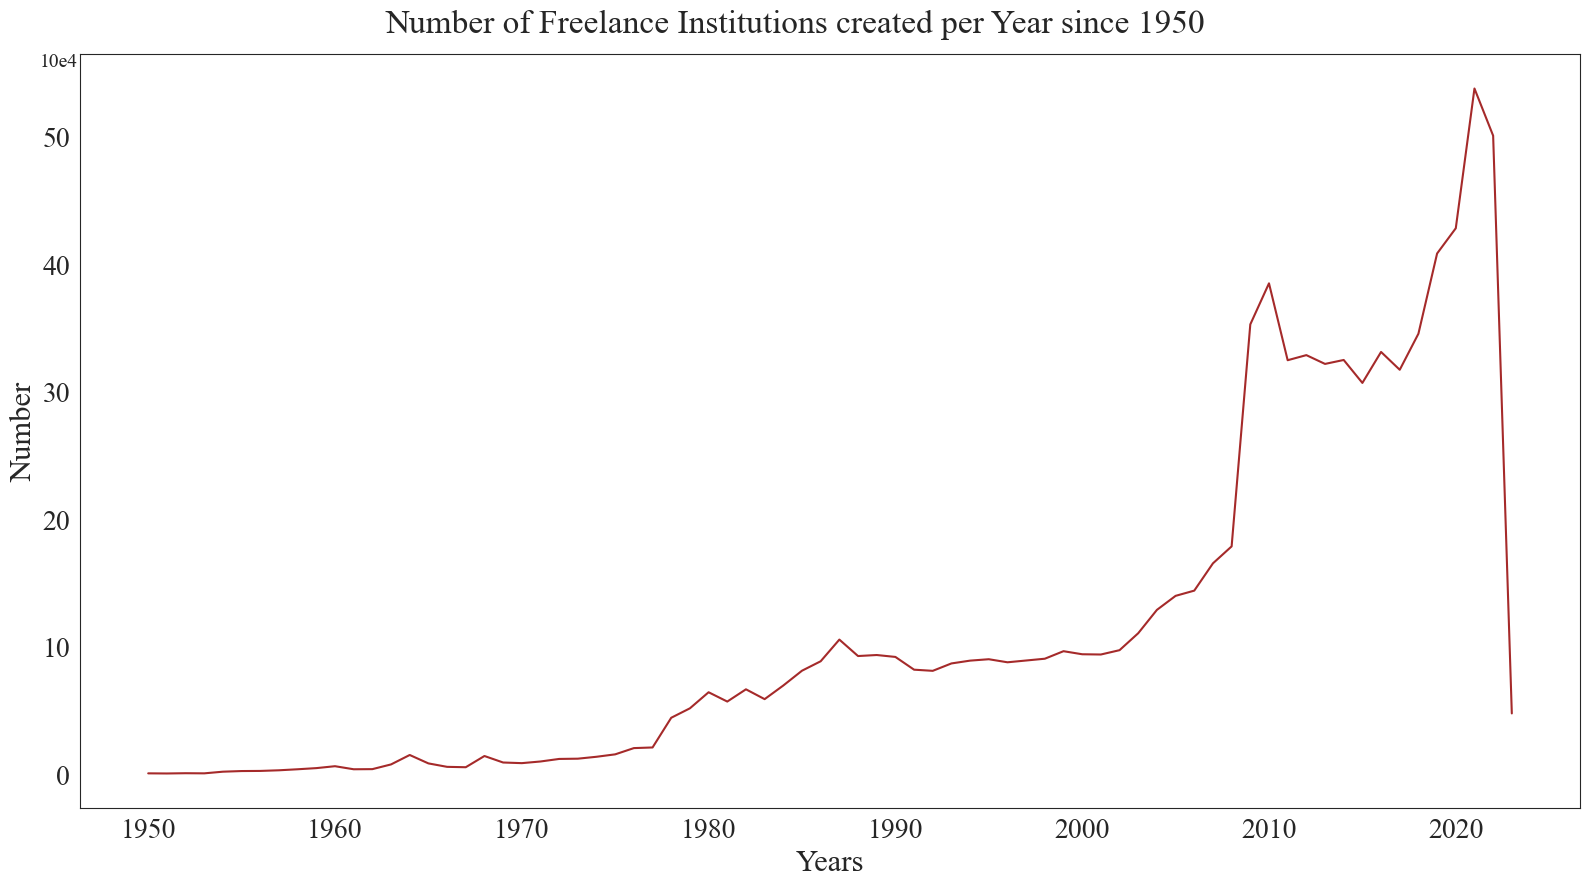

In [111]:
# Build the Figure
sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(16, 9), sharey=True)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rc('font',family='Times New Roman')

# Axis
ax = sns.lineplot(x = 'YEAR_CREATION', y = 'count', data=df_freelance_on, color='brown')
ax.set_xlabel("Years", size=22)
ax.set_ylabel("Number", size=22)
plt.setp(ax.get_xticklabels(), fontsize=20)
plt.setp(ax.get_yticklabels(), fontsize=20)

# Annotation
plt.text(1945.2, 55.5, '10e4', ha="center", fontsize = 14, fontname = "Times New Roman")

#Figure
fig.suptitle("Number of Freelance Institutions created per Year since 1950", ha = 'center', size=24)
fig.tight_layout()

#Save Figure
pathFile = os.path.join(pathFigures, 'Création & Cessation - Unité Légale', "Lineplot - Number of Freelance Institutions created per Year since 1950")
os.makedirs(os.path.dirname(pathFile), exist_ok=True)
fig.savefig(pathFile)

- Freelance and Non-Freelance Institutions

In [136]:
df_freelance_nonfreelance = df_freelance[['SECTION', 'etatAdministratifUniteLegale', 'IS_FREELANCE', 'YEAR_CREATION']][(1950 <= df_freelance.YEAR_CREATION) & (df_freelance.YEAR_CREATION <= datetime.datetime.today().year)]
df_freelance_nonfreelance = df_freelance_nonfreelance.groupby(['IS_FREELANCE', 'YEAR_CREATION'])['YEAR_CREATION'].count().reset_index(name="count")
df_freelance_nonfreelance['count'] = round(df_freelance_nonfreelance['count']/10000, 2)
df_freelance_nonfreelance.sample()

,IS_FREELANCE,YEAR_CREATION,count
39,False,1989,10.49


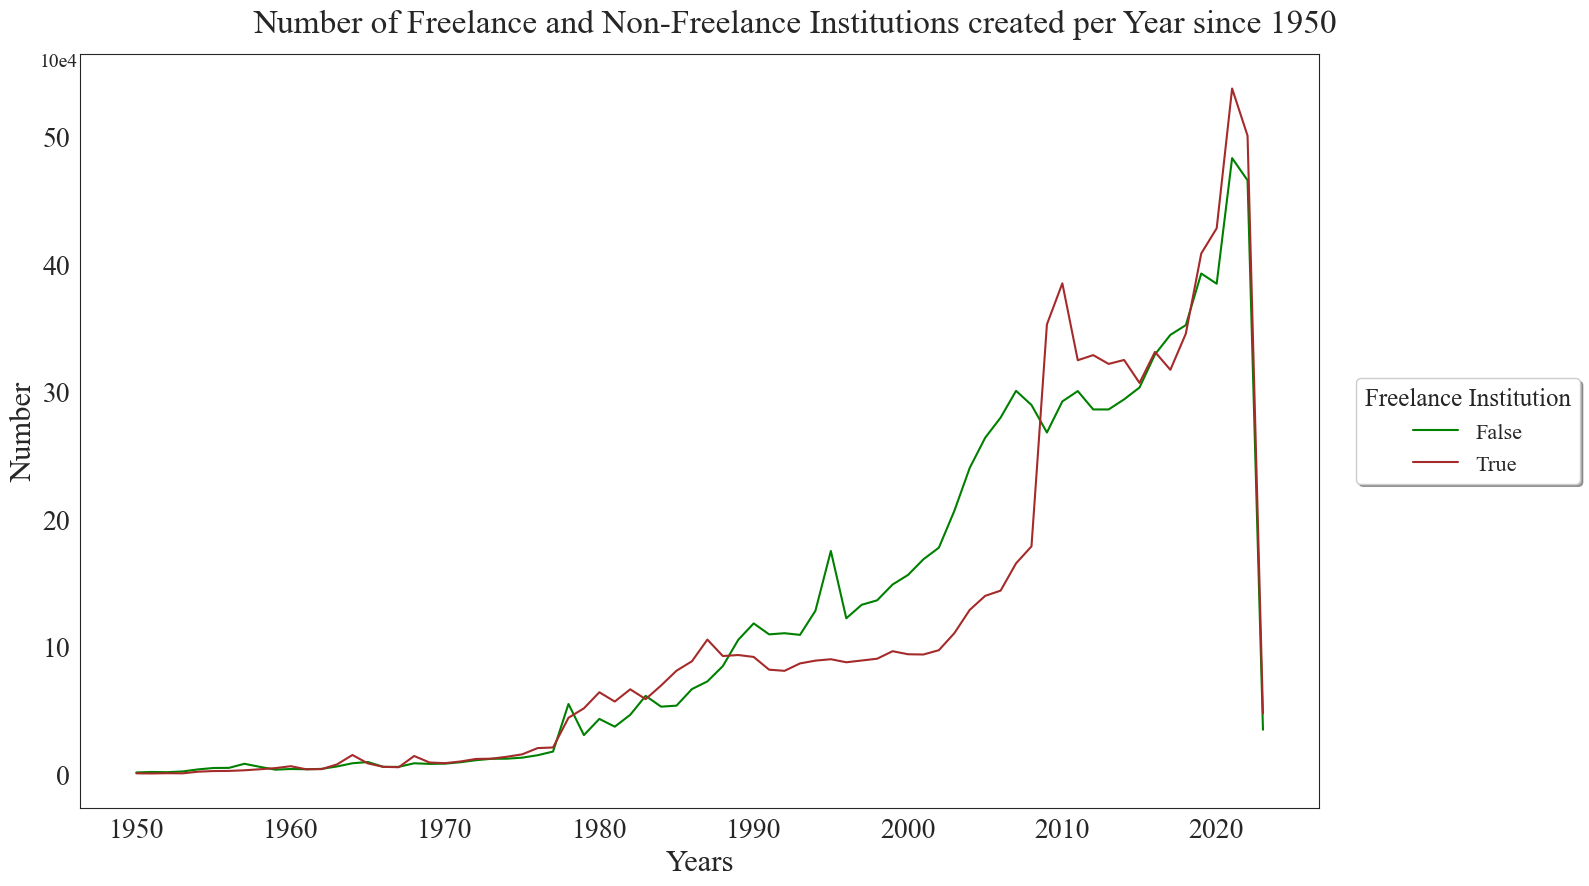

In [137]:
# Build the Figure
sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(16, 9), sharey=True)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rc('font',family='Times New Roman')

# Axis
ax = sns.lineplot(x = 'YEAR_CREATION', y = 'count', hue='IS_FREELANCE', data=df_freelance_nonfreelance, palette=['green', 'brown'])
ax.set_xlabel("Years", size=22)
ax.set_ylabel("Number", size=22)
plt.setp(ax.get_xticklabels(), fontsize=20)
plt.setp(ax.get_yticklabels(), fontsize=20)

# Annotation
plt.text(1945, 55.5, '10e4', ha="center", fontsize = 14, fontname = "Times New Roman")

leg = ax.legend(loc='center', bbox_to_anchor=(1.12, 0.5), shadow=True, prop={'size':16, 'family': 'Times New Roman' }, labelspacing=0.5)
leg.set_title('Freelance Institution', prop = {'size': 18, 'family':'Times New Roman'})


#Figure
fig.suptitle("Number of Freelance and Non-Freelance Institutions created per Year since 1950", ha = 'center', size=24)
fig.tight_layout()

#Save Figure
pathFile = os.path.join(pathFigures, 'Création & Cessation - Unité Légale', "Lineplot - Number of Freelance and Non-Freelance Institutions created per Year since 1950")
os.makedirs(os.path.dirname(pathFile), exist_ok=True)
fig.savefig(pathFile)

##### -> Gender

- Gender Institutions

In [251]:
df_gender = df_freelance[['SECTION', 'etatAdministratifUniteLegale', 'YEAR_CREATION', 'sexeUniteLegale']][(1950 <= df_freelance.YEAR_CREATION) & (df_freelance.YEAR_CREATION <= datetime.datetime.today().year)]
df_gender['sexeUniteLegale'].fillna("No Information",inplace=True)
df_gender.loc[df_gender['sexeUniteLegale']=='M', 'sexeUniteLegale'] = "Male"
df_gender.loc[df_gender['sexeUniteLegale']=='F', 'sexeUniteLegale'] = "Female"
df_gender = df_gender.groupby(['YEAR_CREATION', 'sexeUniteLegale'])['YEAR_CREATION'].count().reset_index(name="count")
df_gender['count'] = round(df_gender['count']/10000, 2)
df_gender.sample()

,YEAR_CREATION,sexeUniteLegale,count
101,1983,No Information,6.1


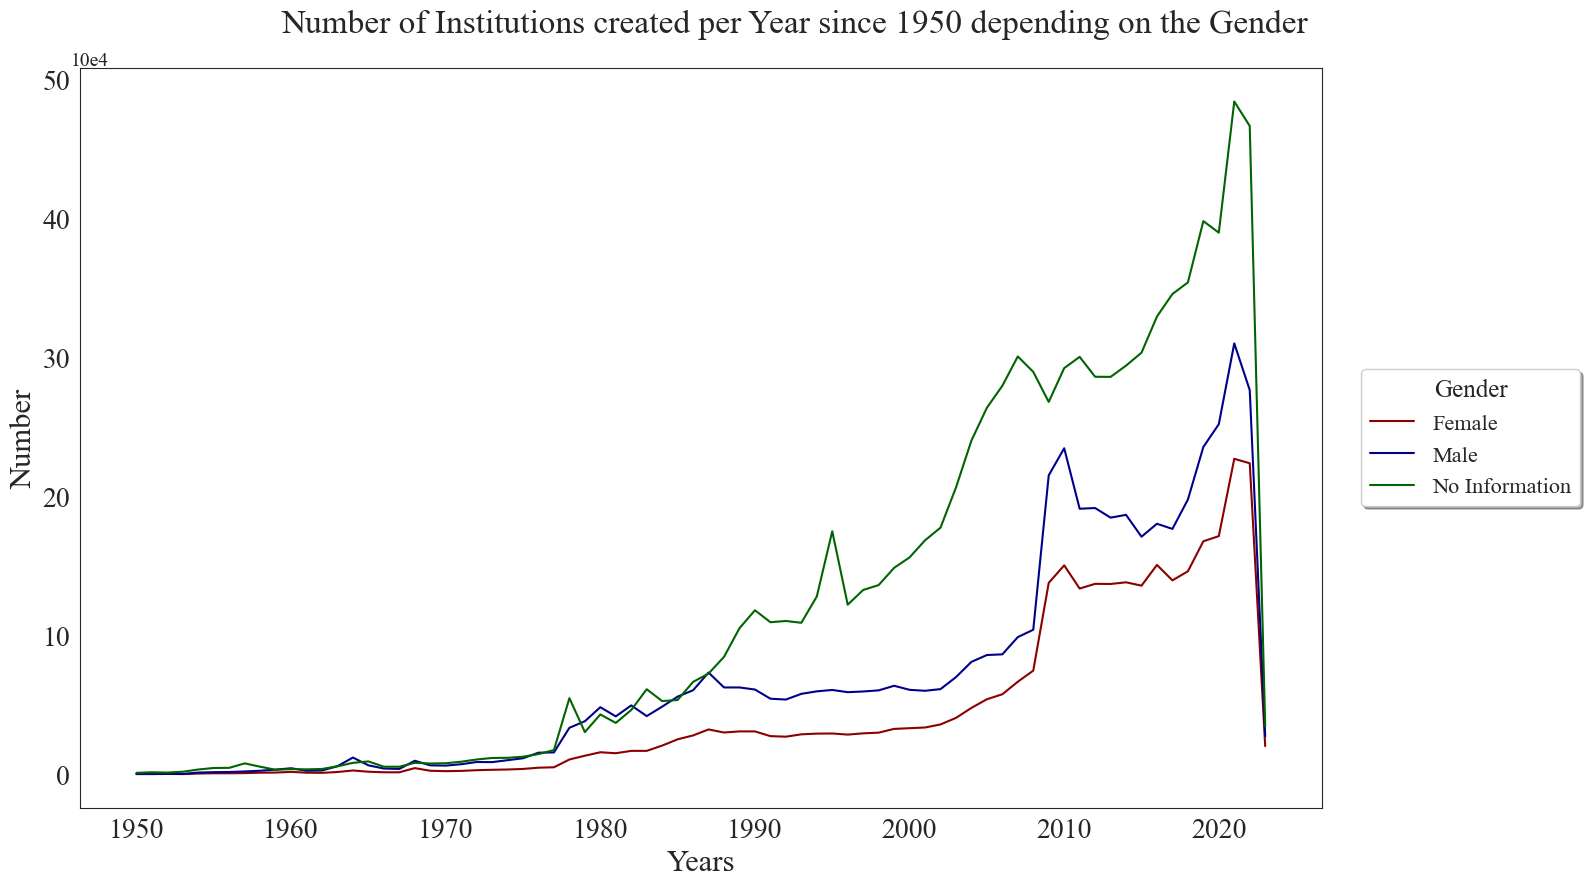

In [252]:
# Build the Figure
sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(16, 9), sharey=True)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rc('font',family='Times New Roman')

# Axis
ax = sns.lineplot(x = 'YEAR_CREATION', y = 'count', hue='sexeUniteLegale', data=df_gender, palette=['darkred', 'darkblue', 'darkgreen'])
ax.set_xlabel("Years", size=22)
ax.set_ylabel("Number", size=22)
plt.setp(ax.get_xticklabels(), fontsize=20)
plt.setp(ax.get_yticklabels(), fontsize=20)

# Annotation
plt.text(1947, 51, '10e4', ha="center", fontsize = 14, fontname = "Times New Roman")

leg = ax.legend(loc='center', bbox_to_anchor=(1.12, 0.5), shadow=True, prop={'size':16, 'family': 'Times New Roman' }, labelspacing=0.5)
leg.set_title('Gender', prop = {'size': 18, 'family':'Times New Roman'})


#Figure
fig.suptitle("Number of Institutions created per Year since 1950 depending on the Gender", ha = 'center', size=24)
fig.tight_layout()

#Save Figure
pathFile = os.path.join(pathFigures, 'Création & Cessation - Unité Légale', "Number of Institutions created per Year since 1950 depending on the Gender")
os.makedirs(os.path.dirname(pathFile), exist_ok=True)
fig.savefig(pathFile)

- Gender Institutions and Administative State

In [260]:
df_gender_as = df_freelance[['SECTION', 'etatAdministratifUniteLegale', 'YEAR_CREATION', 'sexeUniteLegale']][(1950 <= df_freelance.YEAR_CREATION) & (df_freelance.YEAR_CREATION <= datetime.datetime.today().year)]
df_gender_as['sexeUniteLegale'].fillna("No Information",inplace=True)
df_gender_as.loc[df_gender_as['sexeUniteLegale']=='M', 'sexeUniteLegale'] = "Male"
df_gender_as.loc[df_gender_as['sexeUniteLegale']=='F', 'sexeUniteLegale'] = "Female"
df_gender_as = df_gender_as.groupby(['YEAR_CREATION', 'etatAdministratifUniteLegale', 'sexeUniteLegale'])['YEAR_CREATION'].count().reset_index(name="count")
df_gender_as['count'] = round(df_gender_as['count']/10000, 2)
df_gender_as.sample()

,YEAR_CREATION,etatAdministratifUniteLegale,sexeUniteLegale,count
196,1982,Closed,Male,2.36


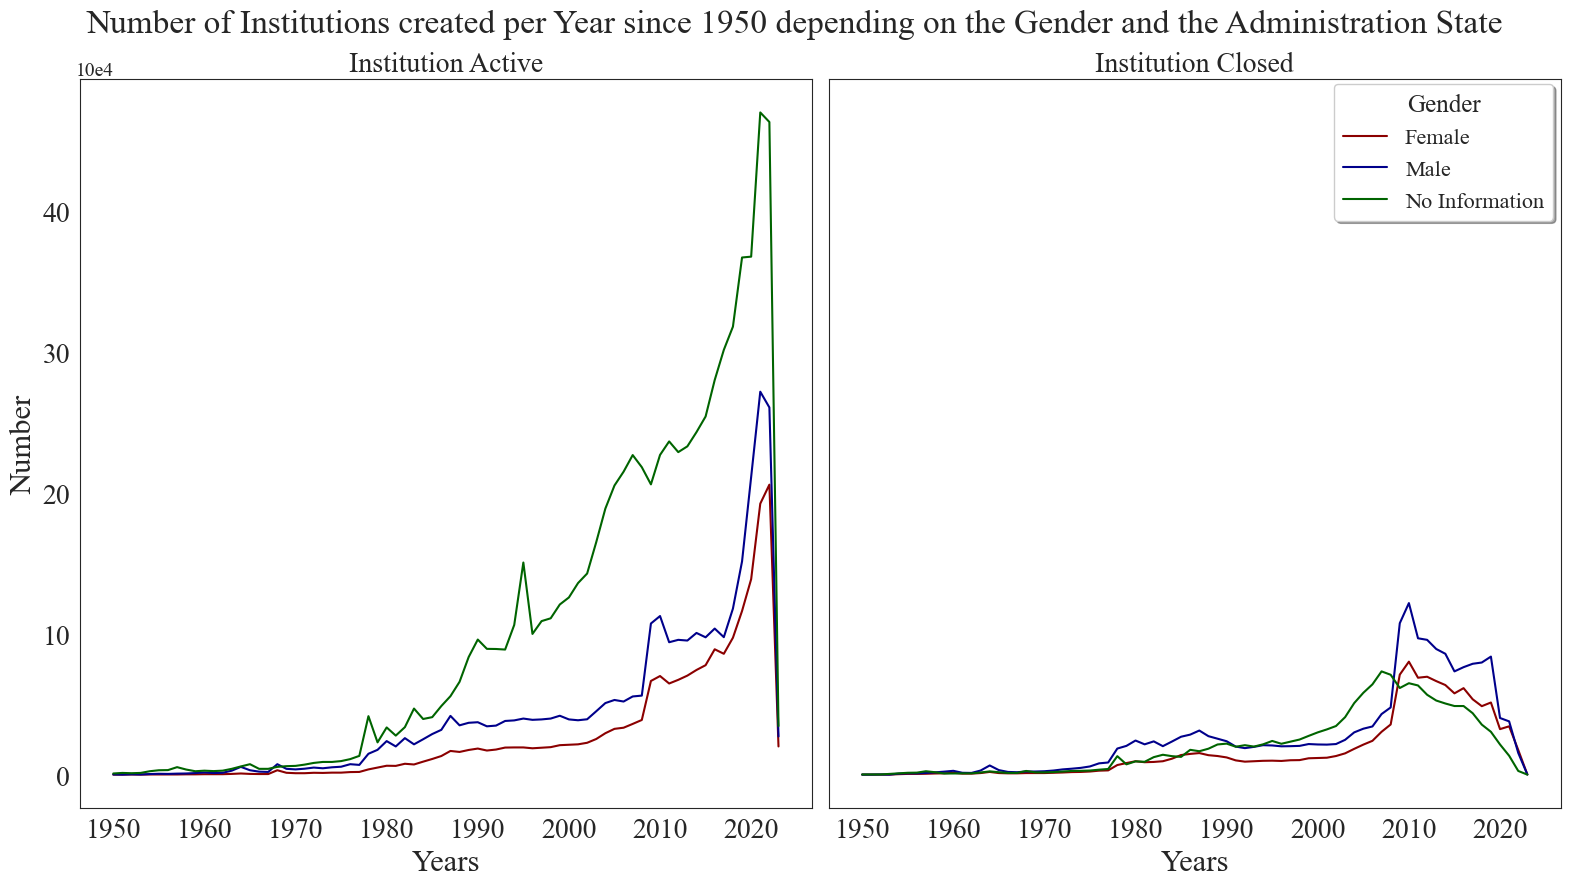

In [261]:
# Build the Figure
sns.set_style("white")
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 9), sharey=True)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rc('font',family='Times New Roman')

# Axis
sns.lineplot(x = 'YEAR_CREATION', y = 'count', hue='sexeUniteLegale', data=df_gender_as[df_gender_as['etatAdministratifUniteLegale']=='Active'], palette=['darkred', 'darkblue', 'darkgreen'], ax=ax1)
ax1.set_xlabel("Years", size=22)
ax1.set_ylabel("Number", size=22)
plt.setp(ax1.get_xticklabels(), fontsize=20)
plt.setp(ax1.get_yticklabels(), fontsize=20)
ax1.legend([], [], frameon=False)
ax1.set_title('Institution Active', ha = 'center', size=20)


sns.lineplot(x = 'YEAR_CREATION', y = 'count', hue='sexeUniteLegale', data=df_gender_as[df_gender_as['etatAdministratifUniteLegale']=='Closed'], palette=['darkred', 'darkblue', 'darkgreen'], ax=ax2)
ax2.set_xlabel("Years", size=22)
plt.setp(ax2.get_xticklabels(), fontsize=20)
ax2.set_title('Institution Closed', ha = 'center', size=20)

leg = ax2.legend(loc='center', bbox_to_anchor=(0.84, 0.9), shadow=True, prop={'size':16, 'family': 'Times New Roman' }, labelspacing=0.5)
leg.set_title('Gender', prop = {'size': 18, 'family':'Times New Roman'})

# Annotation
ax1.text(1948, 49.7, '10e4', ha="center", fontsize = 14, fontname = "Times New Roman")


#Figure
fig.suptitle("Number of Institutions created per Year since 1950 depending on the Gender and the Administration State", ha = 'center', size=24)
fig.tight_layout()

#Save Figure
pathFile = os.path.join(pathFigures, 'Création & Cessation - Unité Légale', "Number of Institutions created per Year since 1950 depending on the Gender and the Administration State")
os.makedirs(os.path.dirname(pathFile), exist_ok=True)
fig.savefig(pathFile)

##### -> Department

- ZipCode and Institution creation Year

In [221]:
df_zip_ci = df_freelance[['SECTION', 'etatAdministratifUniteLegale', 'YEAR_CREATION', 'sexeUniteLegale', 'codePostalEtablissement']][(2000 <= df_freelance.YEAR_CREATION) & (df_freelance.YEAR_CREATION <= datetime.datetime.today().year-1)]
df_zip_ci['zipCode'] = df_zip_ci['codePostalEtablissement'].apply(lambda valcode : str(valcode)[:2])
df_zip_ci = df_zip_ci.groupby(['YEAR_CREATION', 'zipCode'])['YEAR_CREATION'].count().reset_index(name="count")
df_zip_ci['count'] = round(df_zip_ci['count']/10000, 2)
df_zip_ci.sample(3)

,YEAR_CREATION,zipCode,count
1935,2021,55,0.16
1919,2021,39,0.27
1615,2017,95,1.22


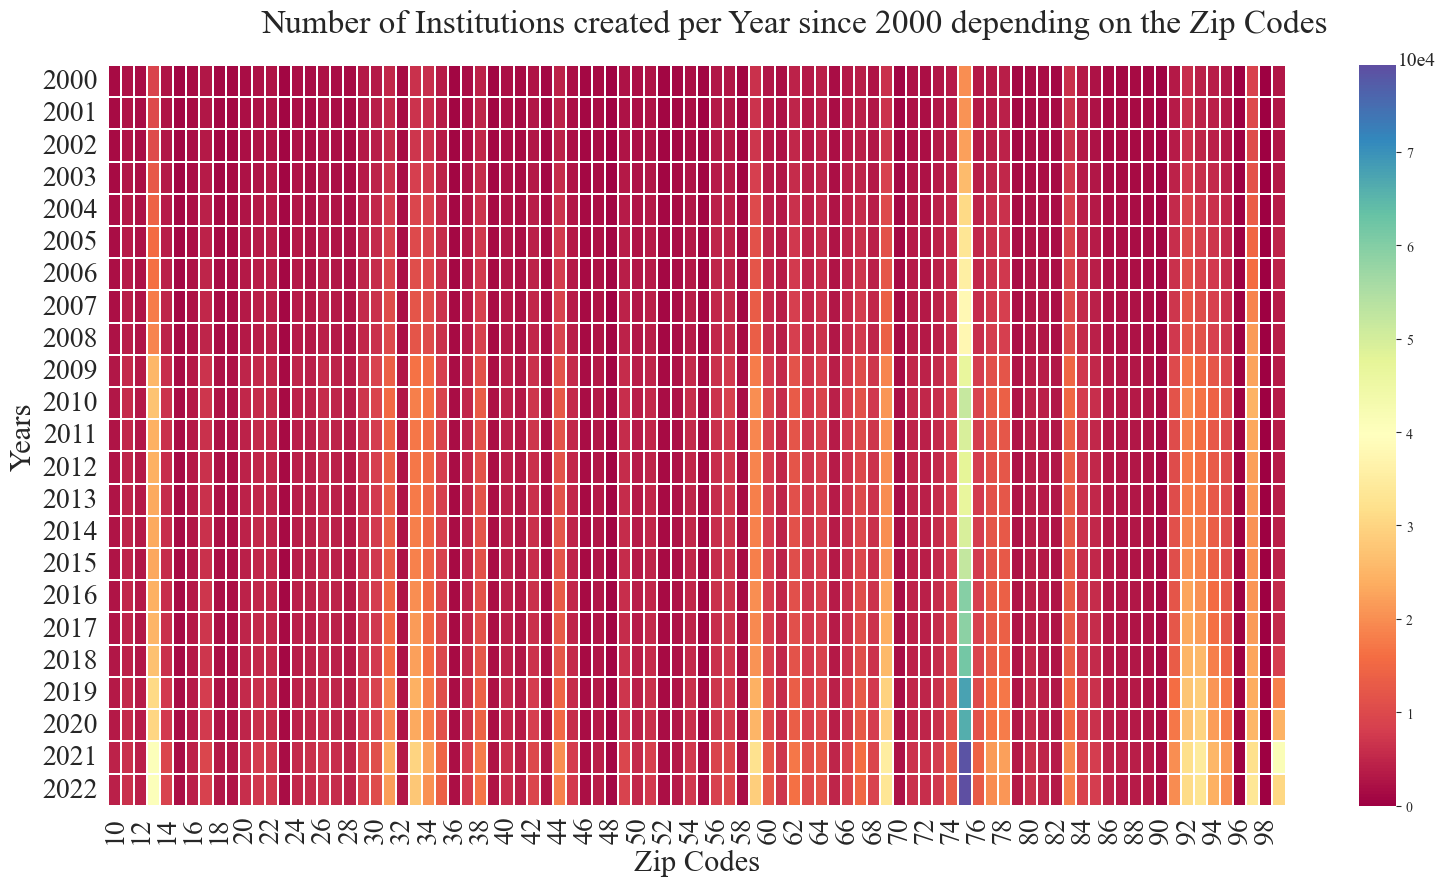

In [248]:
# Build the Figure
sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(16, 9), sharey=True)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rc('font',family='Times New Roman')

# Axis
pivot_zip_ci = df_zip_ci.pivot(index='YEAR_CREATION', columns='zipCode', values='count')
ax = sns.heatmap(pivot_zip_ci, linewidths=.1, cmap='Spectral')
ax.set_xlabel("Zip Codes", size=22)
ax.set_ylabel("Years", size=22)
plt.setp(ax.get_xticklabels(), fontsize=20, rotation=90)
plt.setp(ax.get_yticklabels(), fontsize=20, rotation=0)

# Annotation
plt.text(100, 0, '10e4', ha="center", fontsize = 14, fontname = "Times New Roman")

#Figure
fig.suptitle("Number of Institutions created per Year since 2000 depending on the Zip Codes", ha = 'center', size=24)
fig.tight_layout()

#Save Figure
pathFile = os.path.join(pathFigures, 'Création & Cessation - Unité Légale', "Number of Institutions created per Year since 2000 depending on the Zip Codes")
os.makedirs(os.path.dirname(pathFile), exist_ok=True)
fig.savefig(pathFile)